# Random Search and Hill Climbing on CartPole-v0
Based on: http://kvfrans.com/simple-algoritms-for-solving-cartpole/  

In [865]:
import matplotlib.pyplot as plt
%matplotlib inline 

import gym
import numpy as np
import time
import tensorflow as tf

# Parameters
timeSteps = 200 # Time steps per episode
randomTimeSteps = 10000 # Time steps for multiepisodic training
observationSpace = 4 # Size of CartPole-v0 observation vector
actionSpace = 2 # Size of CartPole-v0 action vector
noise = 0.001 # Noise scaling for hill climbing
noiseStep = 0.001 # Noise increase for hill climbing

## CartPole-v0  
I run a random simulation of the environement to get an idea of how the observations and actions look, and what balancing the pole without an optimal policy looks like. For the following experiments, a terminal state is defined as 1) when pole fails to be balanced or 2) when t = 200 timesteps. Solving is defined here https://gym.openai.com/envs/CartPole-v0/ as achieving an average cumulative reward of 195.0+ over 100 consecutive trials. 

In [900]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done == True:
        print('Done on timestep:', _)
        print('Example of action:', action)
        print('Example of observation:', observation)
        break 
env.render(close=True)

[2017-12-15 21:51:01,855] Making new env: CartPole-v0


Done on timestep: 31
Example of action: 0
Example of observation: [-0.10130247 -0.83506247  0.21682023  1.65809761]


**run_episode(env, parameters)** takes weights and environment as input and returns total reward for linear approximation.  
**run_10_trials(env, parameters)** takes weights and environment as input and prints the results of running the environment 100 times for a 10 trials with the weights. 

In [947]:
def run_episode(env, parameters):
    observation = env.reset()
    totalReward = 0
    for i in range(timeSteps):
        # Choose action based on linear approximation
        if np.matmul(observation, parameters) < 0: 
            action = 0
        else: 
            action = 1
        # Take a step in the environment
        observation, reward, done, info = env.step(action)
        # Append non-discounted cumulative reward 
        totalReward += reward 
        # If done, end the episode 
        if done:
            break 
    return totalReward 

def run_10_trials(env, parameters):
    print('Using the following best parameters: ', parameters)
    for i in range(10):
        overallReward = []
        for j in range(100):
            episodeReward = run_episode(env, parameters)
            overallReward.append(episodeReward)
        print('Trial', i, ': The average reward over 100 consecutive trials is:', np.mean(overallReward), 'and the max reward is:', np.max(overallReward))

## Random Search Algorithm
Generate 10,000 random configurations of parameters and find the set of weights that returns the greatest cumulative reward per episode. 

Episode: 0 , Best Params: [ 0.15168838  0.86322282 -0.47353671  0.5841737 ] , Episode Reward: 9.0
Episode: 3 , Best Params: [ 0.55149192  0.43250818  0.29038242  0.58593235] , Episode Reward: 10.0
Episode: 6 , Best Params: [ 0.55149192  0.43250818  0.29038242  0.58593235] , Episode Reward: 37.0
Episode: 9 , Best Params: [ 0.55149192  0.43250818  0.29038242  0.58593235] , Episode Reward: 9.0
Episode: 12 , Best Params: [-0.32372492  0.15901937  0.96234089  0.91835329] , Episode Reward: 119.0
Episode: 15 , Best Params: [-0.32372492  0.15901937  0.96234089  0.91835329] , Episode Reward: 10.0
Episode: 18 , Best Params: [-0.32372492  0.15901937  0.96234089  0.91835329] , Episode Reward: 141.0
Episode: 1000 , Best Params: [-0.32372492  0.15901937  0.96234089  0.91835329] , Episode Reward: 158.0
Episode: 2000 , Best Params: [-0.32372492  0.15901937  0.96234089  0.91835329] , Episode Reward: 103.0
Episode: 3000 , Best Params: [-0.32372492  0.15901937  0.96234089  0.91835329] , Episode Reward: 9

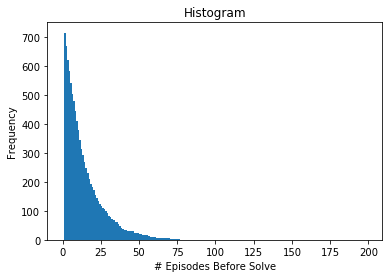

In [921]:
start_time = time.time() 
bestParameters = None 
bestTotalReward = 0 

episodeBeforeSolve = []
startEpisode = 0
endEpisode = 0

for _ in range(randomTimeSteps):
    env.reset()
    endEpisode = _ 
    
    # Make random parameters 
    episodeParameters = np.random.uniform(-1, 1, size = observationSpace)
    
    # Run episode with random parameters
    episodeReward = run_episode(env, episodeParameters)
    if episodeReward > bestTotalReward: 
        bestTotalReward = episodeReward 
        bestParameters = episodeParameters 
    else: 
        bestTotalReward = bestTotalReward
        bestParameters = bestParameters  
    
    # Get time steps until solve
    episodeBeforeSolve.append(endEpisode - startEpisode)
    if episodeReward == timeSteps:
        startEpisode = endEpisode
        
    # Training log 
    if _ < 20:
        if _ % 3 == 0: 
            print('Episode:', _, ', Best Params:', bestParameters, ', Episode Reward:', episodeReward)
    else:
        if _ % 1000 == 0:
            print('Episode:', _, ', Best Params:', bestParameters, ', Episode Reward:', episodeReward)
            

end_time = time.time()
print('Total random search training time:', end_time - start_time, 'seconds')

# Plot weight distribution
n = plt.hist(episodeBeforeSolve, bins = range(200))
plt.title('Histogram')
plt.xlabel('# Episodes Before Solve')
plt.ylabel('Frequency')

average = sum(episodeBeforeSolve)/len(episodeBeforeSolve)
print('Average episodes to reach 200 timesteps:', average)

We then take the best policy weights and determine if the environment is solved by running 100 consecutive trials and finding the average cumulative reward. Clearly, the random search algorithm performs well by getting average scores of over 195.0+ for 3 experimental trials, demonstrating the reproducibility of the policy. The drawback to this method is that it does not scale well into continuous state/action spaces. Since we only have two actions in this environment, randomly searching will do the trick.

In [948]:
run_10_trials(env, bestParameters)

Using the following best parameters:  [ 10120.41473844 -21620.65029317  41313.47961883  30968.88313772]
Trial 0 : The average reward over 100 consecutive trials is: 167.69 and the max reward is: 200.0
Trial 1 : The average reward over 100 consecutive trials is: 171.56 and the max reward is: 200.0
Trial 2 : The average reward over 100 consecutive trials is: 161.64 and the max reward is: 200.0
Trial 3 : The average reward over 100 consecutive trials is: 164.77 and the max reward is: 200.0
Trial 4 : The average reward over 100 consecutive trials is: 148.57 and the max reward is: 200.0
Trial 5 : The average reward over 100 consecutive trials is: 159.53 and the max reward is: 200.0
Trial 6 : The average reward over 100 consecutive trials is: 159.43 and the max reward is: 200.0
Trial 7 : The average reward over 100 consecutive trials is: 159.57 and the max reward is: 200.0
Trial 8 : The average reward over 100 consecutive trials is: 159.59 and the max reward is: 200.0
Trial 9 : The average r

## Hill Climbing
Initialize random weight and gradually increase in with noise until we find the best set of weights. 

Episode: 1000 , Best Params: [ 1856.37680183 -7200.69253775  7461.0862475   5586.57162402] , Episode Reward: 200.0
Episode: 2000 , Best Params: [   714.03005594   -903.64822383  15101.5121453   11551.5119267 ] , Episode Reward: 200.0
Episode: 3000 , Best Params: [  3550.7745103    5221.56297251  23889.40939149  15833.51515279] , Episode Reward: 200.0
Episode: 4000 , Best Params: [  3033.67445373    621.30953936  36021.51791537  28448.73836001] , Episode Reward: 200.0
Episode: 5000 , Best Params: [  3699.21701003  -3418.23991344  31836.51344487  28305.27313991] , Episode Reward: 200.0
Episode: 6000 , Best Params: [ 10321.14900777  -4731.40019022  28501.4097637   30331.95221915] , Episode Reward: 181.0
Episode: 7000 , Best Params: [ 18702.08758104 -14284.492356    29425.26308084  25601.33172679] , Episode Reward: 111.0
Episode: 8000 , Best Params: [ 16660.79596472 -15549.73703127  29025.38846285  26715.08091774] , Episode Reward: 89.0
Episode: 9000 , Best Params: [ 20267.05302122 -23995.

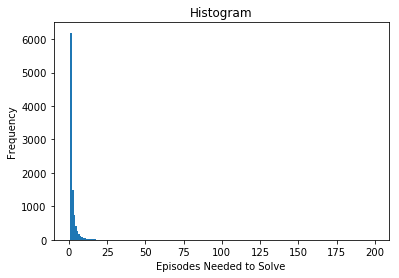

In [942]:
start_time = time.time() 
bestParameters = None 
bestTotalReward = 0 
episodeParameters = np.random.uniform(-1, 1, size = observationSpace)

episodeBeforeSolve = []
startEpisode = 0
endEpisode = 0

for _ in range(randomTimeSteps):
    env.reset()
    endEpisode = _ 
    
    # Random hill climbing 
    episodeNoise = np.random.uniform(-1, 1, size = observationSpace) * noise 
    episodeParameters += episodeNoise
     
    # Run episode with random parameters
    episodeReward = run_episode(env, episodeParameters)
    if episodeReward > bestTotalReward: 
        bestTotalReward = episodeReward 
        bestParameters = episodeParameters 
    else:
        noise += noiseStep
        bestTotalReward = bestTotalReward
        bestParameters = bestParameters  
    
    # Get time steps until solve
    episodeBeforeSolve.append(endEpisode - startEpisode)
    if episodeReward == timeSteps:
        startEpisode = endEpisode

    # Training log 
    if _ % 1000 == 0 and _ != 0:
        print('Episode:', _, ', Best Params:', bestParameters, ', Episode Reward:', episodeReward)

end_time = time.time()
print('Total hill climb training time:', end_time - start_time, 'seconds')

# Plot weight distribution 
n = plt.hist(episodeBeforeSolve, bins = range(200))
plt.title('Histogram')
plt.xlabel('Episodes Needed to Solve')
plt.ylabel('Frequency')

average = sum(episodeBeforeSolve)/len(episodeBeforeSolve)
print('Average episodes to reach 200 timesteps:', average)

We again take the best parameters and perform 3 trials of 100 episodes each. Hill Climbing does not reliably produce a set of good weights that achieve the "solving" goal if we initialize with a bad set of weights. Therefore, we have to repeat running the algorithm to output a good policy that holds the pole up most of the time. 

In [949]:
run_10_trials(env, bestParameters)

Using the following best parameters:  [ 10120.41473844 -21620.65029317  41313.47961883  30968.88313772]
Trial 0 : The average reward over 100 consecutive trials is: 161.38 and the max reward is: 200.0
Trial 1 : The average reward over 100 consecutive trials is: 165.78 and the max reward is: 200.0
Trial 2 : The average reward over 100 consecutive trials is: 161.7 and the max reward is: 200.0
Trial 3 : The average reward over 100 consecutive trials is: 152.47 and the max reward is: 200.0
Trial 4 : The average reward over 100 consecutive trials is: 171.18 and the max reward is: 200.0
Trial 5 : The average reward over 100 consecutive trials is: 154.9 and the max reward is: 200.0
Trial 6 : The average reward over 100 consecutive trials is: 155.76 and the max reward is: 200.0
Trial 7 : The average reward over 100 consecutive trials is: 151.6 and the max reward is: 200.0
Trial 8 : The average reward over 100 consecutive trials is: 156.4 and the max reward is: 200.0
Trial 9 : The average rewar